In [1]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
import malaya_speech
from malaya_speech import Pipeline
import IPython.display as ipd
warnings.filterwarnings("ignore")
from pysptk.sptk import rapt
import gc

1.8.0+cu111


# path

In [2]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# help functions

In [3]:
def norm_mel(y, sr):
    mel = librosa.feature.melspectrogram(y, sr = sr, n_mels = 80,hop_length=512)
    mel = librosa.power_to_db(mel, ref=np.max)
    return mel.T

def plot(y, sr):
    mel = norm_mel(y, sr)
    fig, axs = plt.subplots(2, figsize=(10, 8))
    axs[0].plot(y)
    im = axs[1].imshow(np.rot90(mel), aspect='auto', interpolation='none')
    fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=axs[1])
    print('mel shape:',mel.shape)
    plt.show()

mel shape: (157, 80)


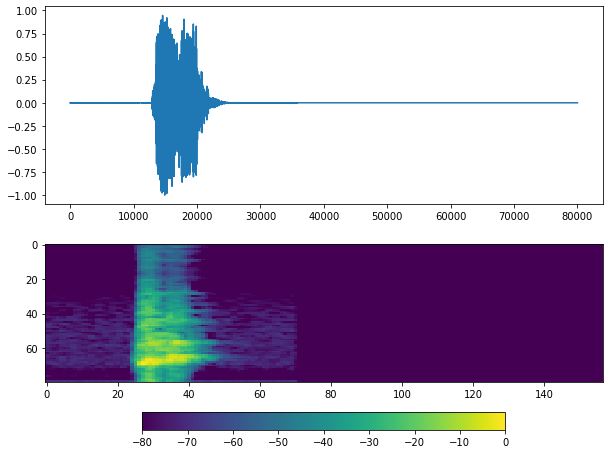

In [4]:
files = os.listdir(X_train_dir)
files.sort()
f = files[40]
y, sr = malaya_speech.load(X_train_dir+f)
plot(y,sr)
ipd.Audio(y, rate = sr)

# 取基頻

mel shape: (1, 80)


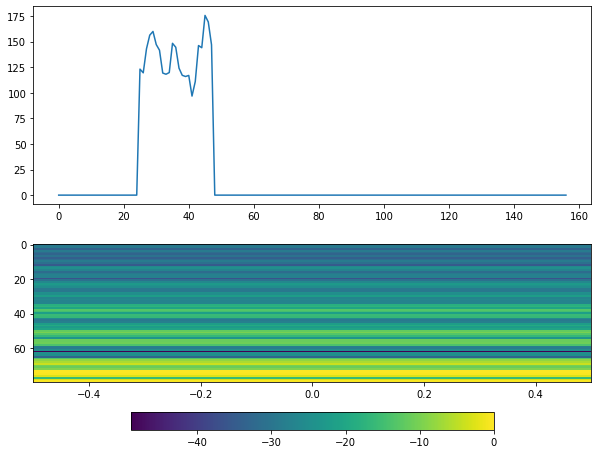

In [5]:
y_基頻 = rapt(y.astype('float32')*32767,sr,hopsize=512)
plot(y_基頻,sr)
ipd.Audio(y_基頻, rate = sr)

# 靜音部分消除

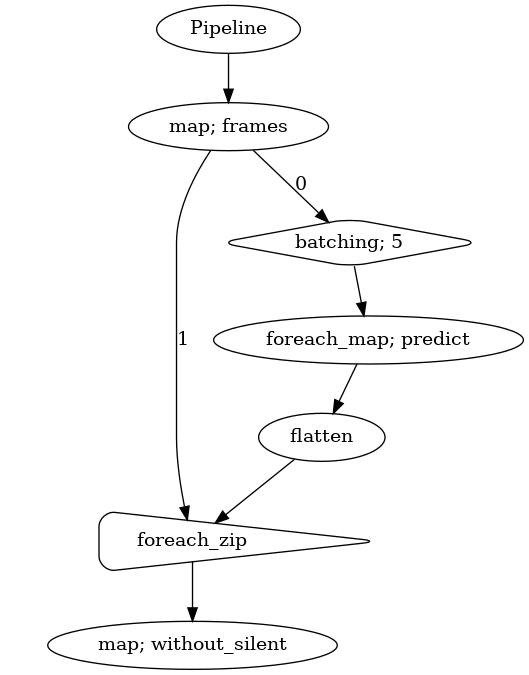

In [6]:
quantized_model = malaya_speech.vad.deep_model(model = 'vggvox-v2', quantized = True)
p = Pipeline()

pipeline_left = (
    p.map(malaya_speech.generator.frames, frame_duration_ms = 30, sample_rate = 16000)
)

pipeline_right = (
    pipeline_left.batching(5)
    .foreach_map(quantized_model.predict)
    .flatten()
)

pipeline_left.foreach_zip(pipeline_right).map(malaya_speech.combine.without_silent,
                                             threshold_to_stop = 0.05)

p.visualize()

In [7]:
def remove_silent(y,sr,time_length=80000):
    y =  p(y)['without_silent']
    if len(y) > time_length:
        y = y[0:0+time_length]
    else:
        y = np.pad(y, (0,time_length-len(y)))
    return y

mel shape: (157, 80)


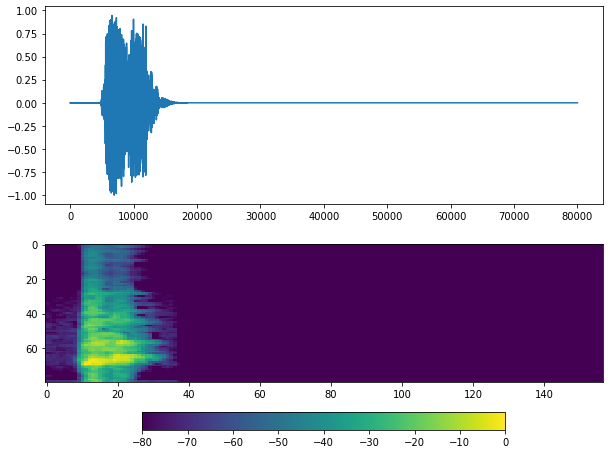

In [8]:
y_without_silent = remove_silent(y,sr)
plot(y_without_silent,sr)
ipd.Audio(y_without_silent, rate = sr)

# mel shape: (157, 80) #固定

# wav 2 features flow

In [9]:
def wav2featuresflow(y, sr):
    y_without_silent = remove_silent(y,sr)
    melspectrogram = np.rot90(norm_mel(y, sr))
    return melspectrogram

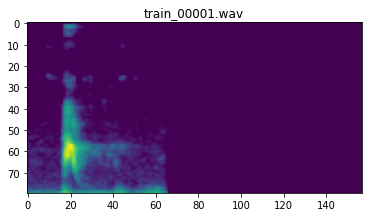

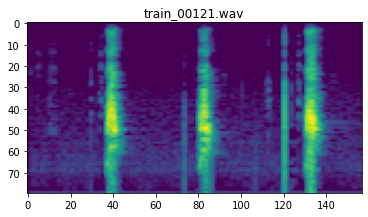

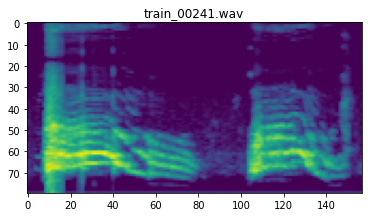

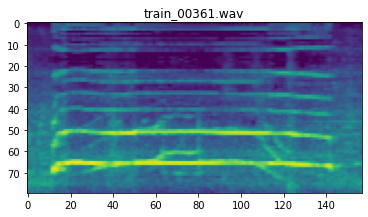

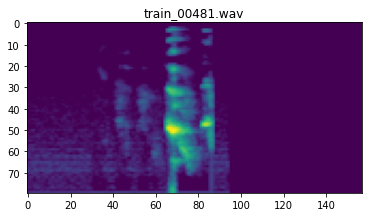

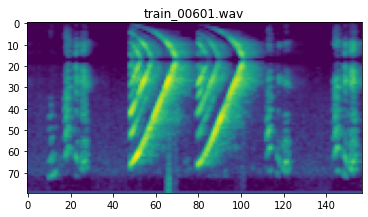

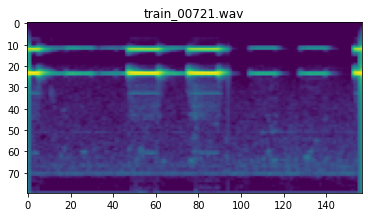

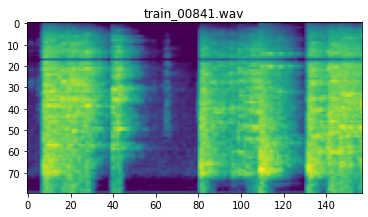

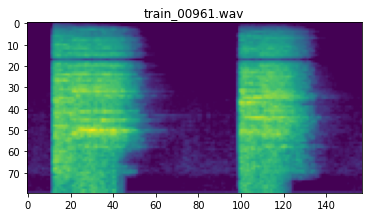

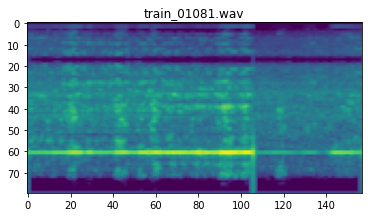

In [10]:
files = os.listdir(X_train_dir)
files.sort()
for f in files[::120]:
    y,sr = malaya_speech.load(X_train_dir+f)
    melspectrogram = wav2featuresflow(y,sr=16000)
    plt.imshow(melspectrogram)
    plt.title(f)
    plt.show()

# preprocessing 

In [11]:
def preprocessing_X(wav_dir):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    X = torch.FloatTensor([])
    for f in tqdm(files[:]):
        try:
            samples, sample_rate = malaya_speech.load(X_train_dir+f)
            melspectrogram = wav2featuresflow(samples,sr=sample_rate)
            melspectrogram = melspectrogram.reshape(-1,80,157).copy()
            melspectrogram = torch.from_numpy(melspectrogram)
            X = torch.cat([X,torch.unsqueeze(melspectrogram,0)],dim=0)
            gc.collect()
        except:
            print(f)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path).iloc[:,:]
    Y = Y[Y.Filename != 'train_01046']
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

# Load X

In [12]:
#X_train = preprocessing_X(X_train_dir)
#torch.save(X_train,'X_train_吳啟聖教的方法.pt')

In [13]:
X_train = torch.load('X_train_吳啟聖教的方法.pt')
#X_train_基頻 = torch.load('X_train_基頻.pt')

In [14]:
#X_test = preprocessing_X(X_test_dir)
#torch.save(X_test,'X_test_吳啟聖教的方法.pt')

In [15]:
X_test = torch.load('X_test_吳啟聖教的方法.pt')
#X_test_基頻 = torch.load('X_test_基頻.pt')

In [16]:
gc.collect()

20014

In [17]:
X_train.shape,X_test.shape

(torch.Size([1199, 1, 80, 157]), torch.Size([10000, 1, 80, 157]))

In [18]:
#X_train_基頻.shape,X_test_基頻.shape

In [19]:
'''
X_train_基頻 = X_train_基頻.reshape(1199,1,1,157)
X_train_基頻_80 = torch.FloatTensor([])
for _ in tqdm(range(80)):
    X_train_基頻_80 = torch.cat([X_train_基頻_80,X_train_基頻],dim=2)
print(X_train_基頻_80.shape)
'''

'\nX_train_基頻 = X_train_基頻.reshape(1199,1,1,157)\nX_train_基頻_80 = torch.FloatTensor([])\nfor _ in tqdm(range(80)):\n    X_train_基頻_80 = torch.cat([X_train_基頻_80,X_train_基頻],dim=2)\nprint(X_train_基頻_80.shape)\n'

In [20]:
'''
X_test_基頻 = X_test_基頻.reshape(10000,1,1,157)
X_test_基頻_80 = torch.FloatTensor([])
for _ in tqdm(range(80)):
    X_test_基頻_80 = torch.cat([X_test_基頻_80,X_test_基頻],dim=2)
print(X_test_基頻_80.shape)
'''

'\nX_test_基頻 = X_test_基頻.reshape(10000,1,1,157)\nX_test_基頻_80 = torch.FloatTensor([])\nfor _ in tqdm(range(80)):\n    X_test_基頻_80 = torch.cat([X_test_基頻_80,X_test_基頻],dim=2)\nprint(X_test_基頻_80.shape)\n'

In [21]:
#X_train = torch.cat([X_train,X_train_基頻_80,],dim=1)
X_train.shape

torch.Size([1199, 1, 80, 157])

In [22]:
#X_test = torch.cat([X_test,X_test_基頻_80,],dim=1)
X_test.shape

torch.Size([10000, 1, 80, 157])

# load Y

In [23]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([1199, 6])
Y_df shape (1199, 3)
torch.Size([1199, 6])


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Vacuum'}

# look some sample

In [24]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

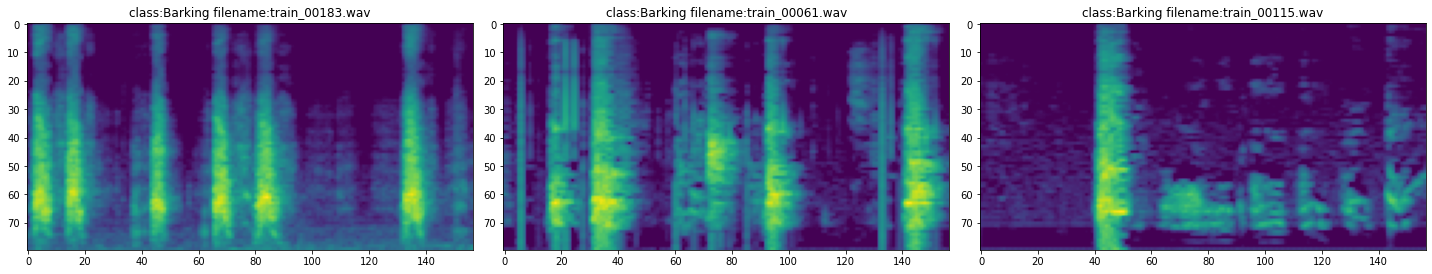

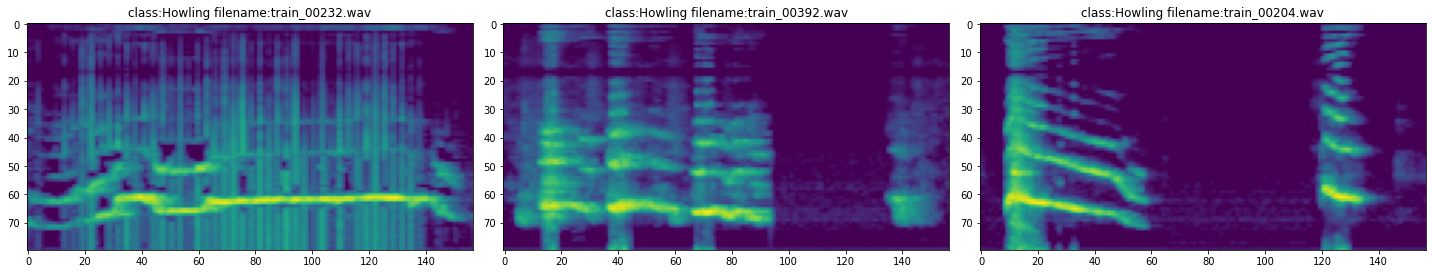

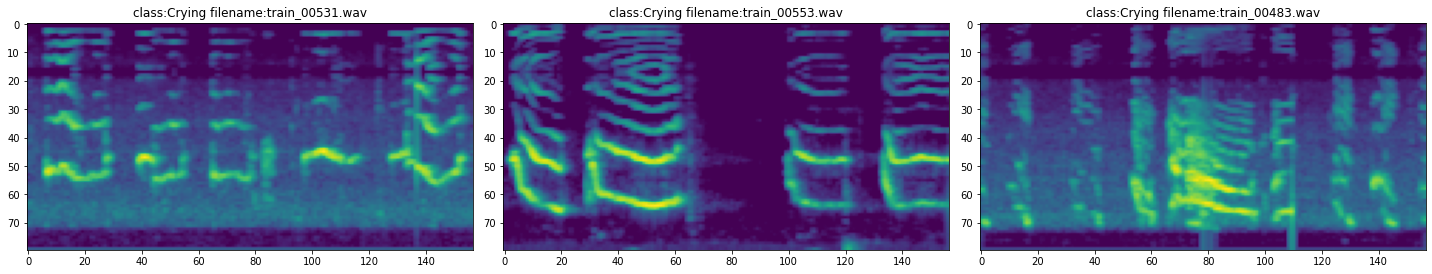

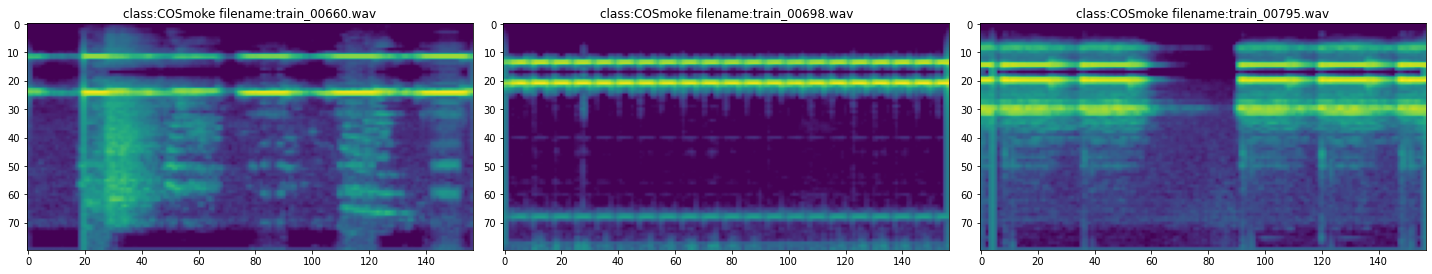

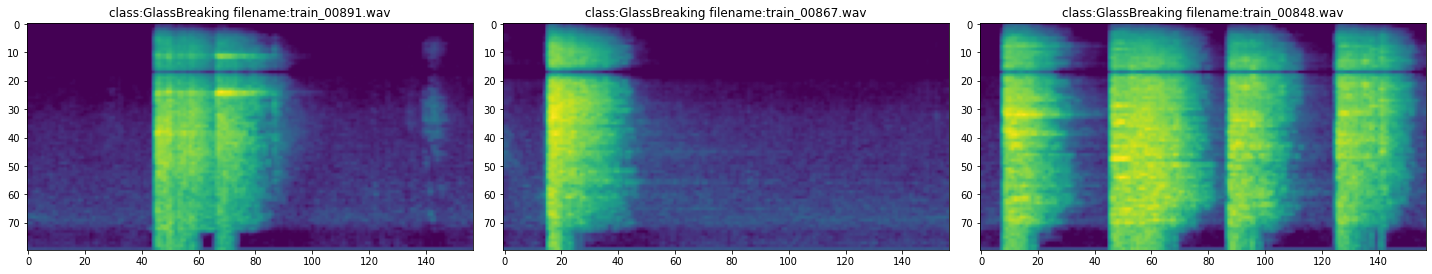

Other


<Figure size 1440x360 with 0 Axes>

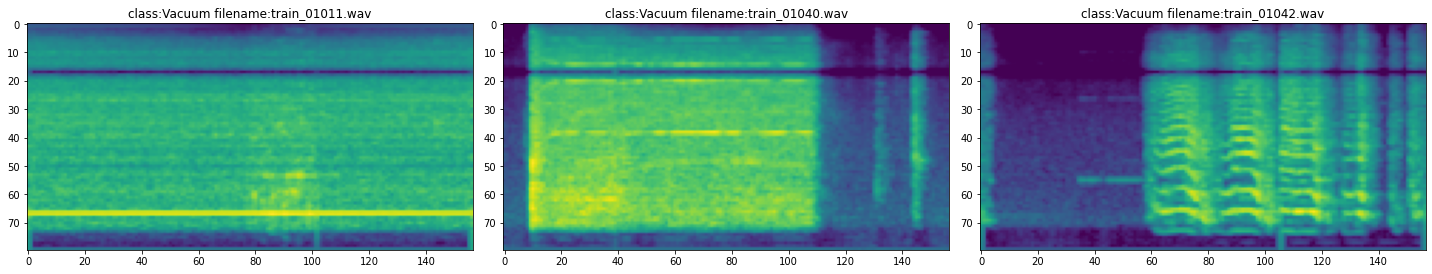

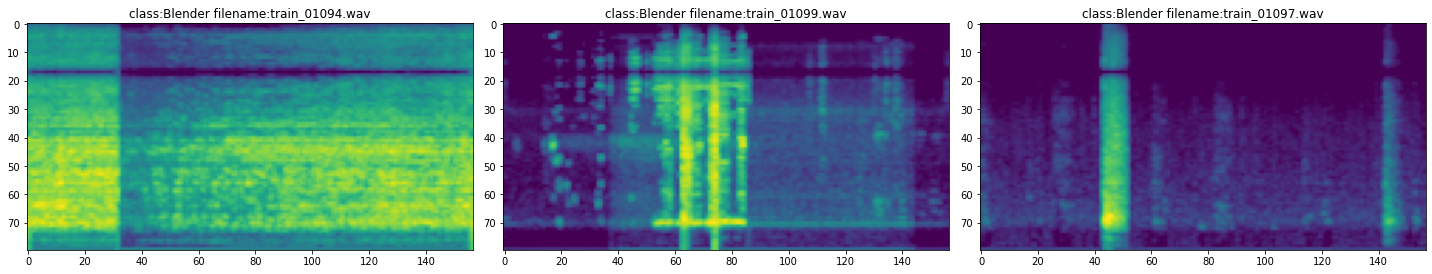

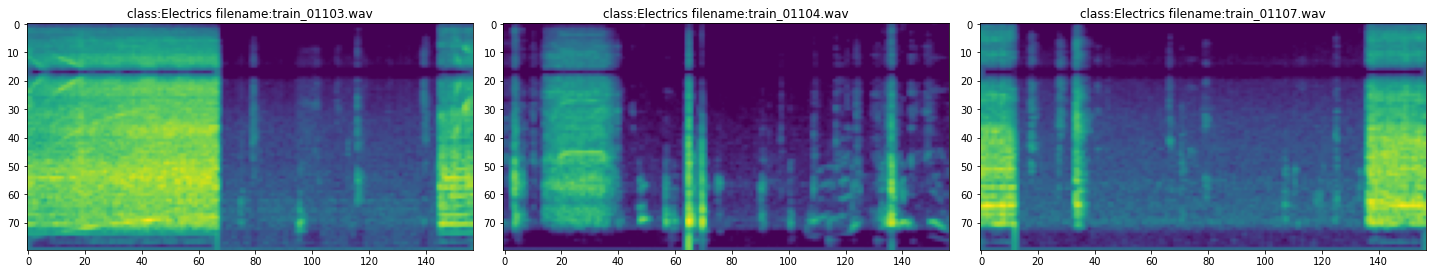

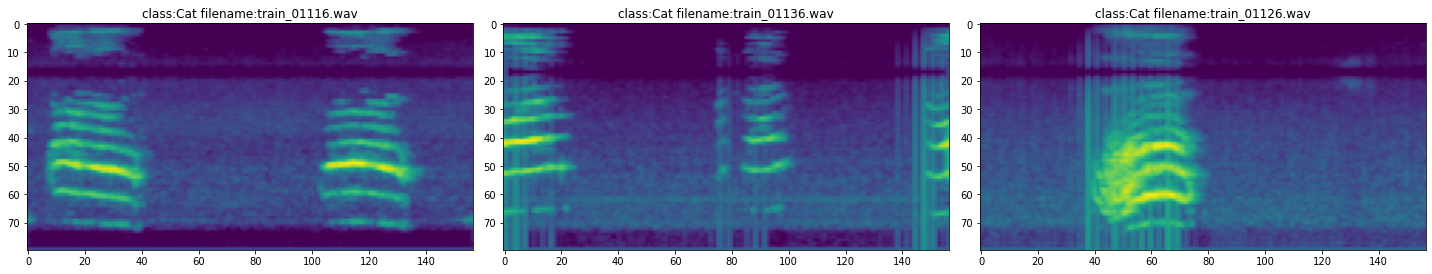

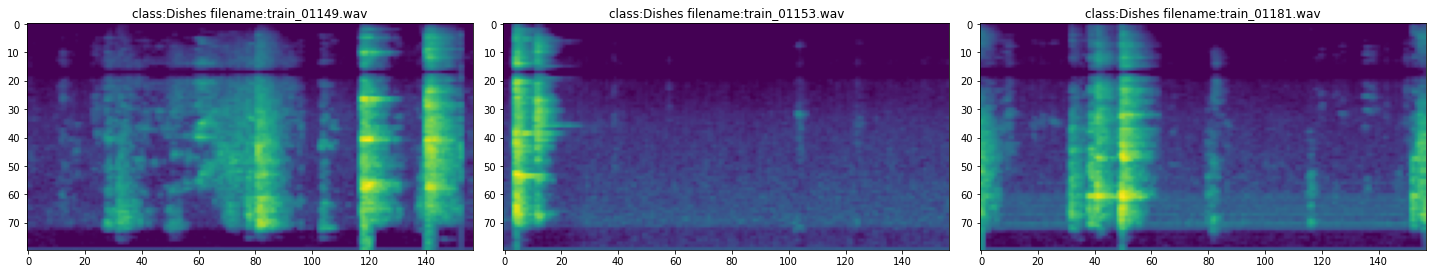

In [25]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_valid , y_train, y_valid = train_test_split(X_train, Y_train, 
                                                       test_size=0.2, 
                                                       random_state=42*5,
                                                       stratify=Y_train)
print(X_train.shape)
print(X_valid.shape)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

torch.Size([959, 1, 80, 157])
torch.Size([240, 1, 80, 157])
0    160
1    160
2    160
3    160
5    160
4    159
dtype: int64
0    40
1    40
2    40
3    40
4    40
5    40
dtype: int64


# 加入外部數據 to X_train

In [27]:
#import joblib
#expansion_data = joblib.load('expansion_data.pkl')
#for k in expansion_data.keys():
#    print(k,len(expansion_data[k]))

In [28]:
#class_idx_map_dict = {}
#class_idx_map_dict['dogbarking'] = 0
#class_idx_map_dict['doghowling'] = 1
#class_idx_map_dict['dogcrying'] = 2
#class_idx_map_dict['GlassBreakingsound'] = 4
#class_idx_map_dict['Electricssound'] = 5
#class_idx_map_dict['Vaccumsound'] = 5
#class_idx_map_dict['dishessound'] = 5
#class_idx_map_dict['Catsound'] = 5

In [29]:
'''
def create_label(batch_size,length=6,class_idx=0):
    y = torch.tensor([[class_idx] for _ in range(batch_size)])
    y_onehot = torch.zeros([batch_size, length])
    return y_onehot.scatter_(1, y, 1)

extra_X_train = torch.FloatTensor([])
extra_y_train = torch.FloatTensor([])
data_idx = {}
for class_name in tqdm(expansion_data.keys()):
    data = expansion_data[class_name][[*range(5,10,1)]]
    label = create_label(batch_size=len(data),length=6,class_idx=class_idx_map_dict[class_name])
    extra_X_train = torch.cat([extra_X_train,data],dim=0)
    extra_y_train = torch.cat([extra_y_train,label],dim=0)
extra_X_train.shape,extra_y_train.shape
'''

'\ndef create_label(batch_size,length=6,class_idx=0):\n    y = torch.tensor([[class_idx] for _ in range(batch_size)])\n    y_onehot = torch.zeros([batch_size, length])\n    return y_onehot.scatter_(1, y, 1)\n\nextra_X_train = torch.FloatTensor([])\nextra_y_train = torch.FloatTensor([])\ndata_idx = {}\nfor class_name in tqdm(expansion_data.keys()):\n    data = expansion_data[class_name][[*range(5,10,1)]]\n    label = create_label(batch_size=len(data),length=6,class_idx=class_idx_map_dict[class_name])\n    extra_X_train = torch.cat([extra_X_train,data],dim=0)\n    extra_y_train = torch.cat([extra_y_train,label],dim=0)\nextra_X_train.shape,extra_y_train.shape\n'

In [30]:
#print(expansion_data.keys())

# 檢視外部數據

In [31]:
#extra_label_df = pd.DataFrame(extra_y_train.argmax(axis=1).detach().numpy(),columns = ['class_name'])
#extra_label_df

In [32]:
'''
def plot_feature_by_class_name(class_name,X,label_df):
    plt.figure(figsize=(20,5))
    i = 0
    for idx,file_idx in enumerate(label_df[label_df.class_name==class_name].sample(3).index):
        feature = X[int(file_idx)]
        plt.subplot(1,3,i+1)
        plt.imshow(feature[0,:,:])
        title = 'class:{} file_idx:{}'.format(class_name,file_idx)
        plt.title(title)
        i+=1
    plt.tight_layout()
    plt.show()
'''

"\ndef plot_feature_by_class_name(class_name,X,label_df):\n    plt.figure(figsize=(20,5))\n    i = 0\n    for idx,file_idx in enumerate(label_df[label_df.class_name==class_name].sample(3).index):\n        feature = X[int(file_idx)]\n        plt.subplot(1,3,i+1)\n        plt.imshow(feature[0,:,:])\n        title = 'class:{} file_idx:{}'.format(class_name,file_idx)\n        plt.title(title)\n        i+=1\n    plt.tight_layout()\n    plt.show()\n"

In [33]:
#for class_name in sorted(extra_label_df.class_name.unique()):
#    plot_feature_by_class_name(class_name,extra_X_train,extra_label_df)

In [34]:
#X_train = torch.cat([X_train,extra_X_train],dim=0)
#X_train.shape

In [35]:
#y_train = torch.cat([y_train,extra_y_train],dim=0)
#y_train.shape

#  create pytorch dataloader and save

In [36]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=32,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=32,num_workers=4)

In [37]:
for bx,by in train_iter:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([32, 1, 80, 157]) cpu
torch.Size([32, 6]) cpu


# define model

In [38]:
import torch.hub
model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
print(model)

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


CifarSEResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): CifarSEBasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=16, out_features=1, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=1, out_features=16, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1)

# model forward test

In [39]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat.shape

torch.Size([32, 1, 80, 157]) torch.Size([32, 6])


torch.Size([32, 6])

# def train loop

In [40]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)
    #return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0 train_loss:0.4860 valid_loss:0.3557 train_auc:0.4382 valid_auc:0.5781
有進步


  2%|▏         | 2/100 [00:18<14:01,  8.59s/it]

epoch:1 train_loss:0.3353 valid_loss:0.2718 train_auc:0.6153 valid_auc:0.6172
有進步


  3%|▎         | 3/100 [00:24<11:37,  7.19s/it]

epoch:2 train_loss:0.2763 valid_loss:0.3014 train_auc:0.7133 valid_auc:0.6094
epoch:3 train_loss:0.2382 valid_loss:0.1905 train_auc:0.7551 valid_auc:0.7656
有進步


  5%|▌         | 5/100 [00:35<09:44,  6.15s/it]

epoch:4 train_loss:0.2055 valid_loss:1.9947 train_auc:0.7790 valid_auc:0.2891


  6%|▌         | 6/100 [00:40<09:25,  6.02s/it]

epoch:5 train_loss:0.1878 valid_loss:0.8074 train_auc:0.7989 valid_auc:0.4023


  7%|▋         | 7/100 [00:46<09:03,  5.85s/it]

epoch:6 train_loss:0.1685 valid_loss:0.3177 train_auc:0.8238 valid_auc:0.6445


  8%|▊         | 8/100 [00:51<08:47,  5.73s/it]

epoch:7 train_loss:0.1519 valid_loss:0.5483 train_auc:0.8311 valid_auc:0.5312


  9%|▉         | 9/100 [00:57<08:33,  5.64s/it]

epoch:8 train_loss:0.1372 valid_loss:0.3467 train_auc:0.8666 valid_auc:0.6367


 10%|█         | 10/100 [01:02<08:21,  5.57s/it]

epoch:9 train_loss:0.1274 valid_loss:0.8416 train_auc:0.8801 valid_auc:0.4023


 11%|█         | 11/100 [01:08<08:11,  5.53s/it]

epoch:10 train_loss:0.1180 valid_loss:0.5935 train_auc:0.8811 valid_auc:0.4805


 12%|█▏        | 12/100 [01:13<08:03,  5.50s/it]

epoch:11 train_loss:0.1114 valid_loss:0.6568 train_auc:0.8884 valid_auc:0.4961


 13%|█▎        | 13/100 [01:19<07:57,  5.49s/it]

epoch:12 train_loss:0.1083 valid_loss:0.1968 train_auc:0.8843 valid_auc:0.7930


 14%|█▍        | 14/100 [01:24<07:50,  5.47s/it]

epoch:13 train_loss:0.1088 valid_loss:0.1560 train_auc:0.8926 valid_auc:0.8164
有進步


 15%|█▌        | 15/100 [01:29<07:44,  5.47s/it]

epoch:14 train_loss:0.0980 valid_loss:0.8262 train_auc:0.9062 valid_auc:0.4766


 16%|█▌        | 16/100 [01:35<07:38,  5.46s/it]

epoch:15 train_loss:0.0825 valid_loss:0.1442 train_auc:0.9166 valid_auc:0.8594
有進步


 17%|█▋        | 17/100 [01:41<07:37,  5.51s/it]

epoch:16 train_loss:0.0824 valid_loss:0.2314 train_auc:0.9176 valid_auc:0.7773


 18%|█▊        | 18/100 [01:46<07:31,  5.50s/it]

epoch:17 train_loss:0.0797 valid_loss:3.5818 train_auc:0.9260 valid_auc:0.1914


 19%|█▉        | 19/100 [01:52<07:25,  5.50s/it]

epoch:18 train_loss:0.0745 valid_loss:1.1247 train_auc:0.9333 valid_auc:0.4375


 20%|██        | 20/100 [01:57<07:15,  5.44s/it]

epoch:19 train_loss:0.0629 valid_loss:0.5618 train_auc:0.9448 valid_auc:0.5039


 21%|██        | 21/100 [02:02<07:11,  5.47s/it]

epoch:20 train_loss:0.0545 valid_loss:0.2902 train_auc:0.9531 valid_auc:0.7383


 22%|██▏       | 22/100 [02:09<07:27,  5.74s/it]

epoch:21 train_loss:0.0504 valid_loss:0.1534 train_auc:0.9583 valid_auc:0.8359


 23%|██▎       | 23/100 [02:14<07:21,  5.74s/it]

epoch:22 train_loss:0.0428 valid_loss:0.2962 train_auc:0.9708 valid_auc:0.6953


 24%|██▍       | 24/100 [02:20<07:13,  5.71s/it]

epoch:23 train_loss:0.0449 valid_loss:0.1951 train_auc:0.9645 valid_auc:0.8086


 25%|██▌       | 25/100 [02:26<07:03,  5.64s/it]

epoch:24 train_loss:0.0514 valid_loss:0.2572 train_auc:0.9593 valid_auc:0.7500


 26%|██▌       | 26/100 [02:31<06:54,  5.61s/it]

epoch:25 train_loss:0.0420 valid_loss:0.1658 train_auc:0.9635 valid_auc:0.8242


 27%|██▋       | 27/100 [02:36<06:44,  5.54s/it]

epoch:26 train_loss:0.0344 valid_loss:0.3629 train_auc:0.9739 valid_auc:0.6836


 28%|██▊       | 28/100 [02:42<06:41,  5.57s/it]

epoch:27 train_loss:0.0401 valid_loss:0.1781 train_auc:0.9677 valid_auc:0.8750


 29%|██▉       | 29/100 [02:48<06:36,  5.58s/it]

epoch:28 train_loss:0.0292 valid_loss:0.1807 train_auc:0.9875 valid_auc:0.8320


 30%|███       | 30/100 [02:53<06:30,  5.57s/it]

epoch:29 train_loss:0.0336 valid_loss:0.2329 train_auc:0.9708 valid_auc:0.7891


 31%|███       | 31/100 [02:59<06:25,  5.58s/it]

epoch:30 train_loss:0.0384 valid_loss:0.2893 train_auc:0.9708 valid_auc:0.7617


 32%|███▏      | 32/100 [03:04<06:15,  5.53s/it]

epoch:31 train_loss:0.0319 valid_loss:0.7428 train_auc:0.9739 valid_auc:0.5039


 33%|███▎      | 33/100 [03:10<06:08,  5.50s/it]

epoch:32 train_loss:0.0294 valid_loss:0.3736 train_auc:0.9781 valid_auc:0.7148


 34%|███▍      | 34/100 [03:15<06:01,  5.48s/it]

epoch:33 train_loss:0.0279 valid_loss:0.1608 train_auc:0.9740 valid_auc:0.8594


 35%|███▌      | 35/100 [03:21<05:55,  5.46s/it]

epoch:34 train_loss:0.0174 valid_loss:0.2001 train_auc:0.9906 valid_auc:0.8516


 36%|███▌      | 36/100 [03:26<05:47,  5.43s/it]

epoch:35 train_loss:0.0149 valid_loss:0.1851 train_auc:0.9927 valid_auc:0.8438


 37%|███▋      | 37/100 [03:31<05:42,  5.44s/it]

epoch:36 train_loss:0.0127 valid_loss:0.1325 train_auc:0.9958 valid_auc:0.8867
有進步


 38%|███▊      | 38/100 [03:37<05:38,  5.47s/it]

epoch:37 train_loss:0.0084 valid_loss:0.2401 train_auc:0.9990 valid_auc:0.8320


 39%|███▉      | 39/100 [03:43<05:37,  5.53s/it]

epoch:38 train_loss:0.0100 valid_loss:0.1708 train_auc:0.9958 valid_auc:0.8594


 40%|████      | 40/100 [03:48<05:31,  5.52s/it]

epoch:39 train_loss:0.0100 valid_loss:0.4777 train_auc:0.9969 valid_auc:0.7344


 41%|████      | 41/100 [03:54<05:25,  5.51s/it]

epoch:40 train_loss:0.0071 valid_loss:0.2040 train_auc:1.0000 valid_auc:0.8398


 42%|████▏     | 42/100 [03:59<05:17,  5.48s/it]

epoch:41 train_loss:0.0065 valid_loss:0.2447 train_auc:0.9979 valid_auc:0.8398


 43%|████▎     | 43/100 [04:04<05:12,  5.48s/it]

epoch:42 train_loss:0.0065 valid_loss:0.1659 train_auc:0.9979 valid_auc:0.8594


 44%|████▍     | 44/100 [04:11<05:24,  5.79s/it]

epoch:43 train_loss:0.0097 valid_loss:0.2387 train_auc:0.9948 valid_auc:0.8320


 45%|████▌     | 45/100 [04:17<05:16,  5.76s/it]

epoch:44 train_loss:0.0126 valid_loss:0.2381 train_auc:0.9916 valid_auc:0.8438


 46%|████▌     | 46/100 [04:23<05:22,  5.98s/it]

epoch:45 train_loss:0.0166 valid_loss:0.2110 train_auc:0.9854 valid_auc:0.8477


 47%|████▋     | 47/100 [04:29<05:08,  5.82s/it]

epoch:46 train_loss:0.0189 valid_loss:0.4639 train_auc:0.9854 valid_auc:0.6836


 48%|████▊     | 48/100 [04:34<05:00,  5.78s/it]

epoch:47 train_loss:0.0186 valid_loss:0.1905 train_auc:0.9885 valid_auc:0.8242


 49%|████▉     | 49/100 [04:40<04:50,  5.69s/it]

epoch:48 train_loss:0.0233 valid_loss:0.5210 train_auc:0.9802 valid_auc:0.6211


 50%|█████     | 50/100 [04:45<04:43,  5.66s/it]

epoch:49 train_loss:0.0165 valid_loss:0.1867 train_auc:0.9875 valid_auc:0.8438


 51%|█████     | 51/100 [04:51<04:34,  5.60s/it]

epoch:50 train_loss:0.0199 valid_loss:0.2457 train_auc:0.9833 valid_auc:0.8320


 52%|█████▏    | 52/100 [04:56<04:27,  5.58s/it]

epoch:51 train_loss:0.0211 valid_loss:0.1879 train_auc:0.9833 valid_auc:0.8398


 53%|█████▎    | 53/100 [05:02<04:20,  5.54s/it]

epoch:52 train_loss:0.0094 valid_loss:0.2132 train_auc:0.9969 valid_auc:0.8359


 54%|█████▍    | 54/100 [05:07<04:13,  5.51s/it]

epoch:53 train_loss:0.0057 valid_loss:0.1696 train_auc:0.9969 valid_auc:0.8711


 55%|█████▌    | 55/100 [05:13<04:07,  5.51s/it]

epoch:54 train_loss:0.0030 valid_loss:0.1613 train_auc:1.0000 valid_auc:0.8750


 56%|█████▌    | 56/100 [05:18<04:01,  5.49s/it]

epoch:55 train_loss:0.0019 valid_loss:0.1420 train_auc:1.0000 valid_auc:0.8906


 57%|█████▋    | 57/100 [05:24<03:55,  5.47s/it]

epoch:56 train_loss:0.0013 valid_loss:0.1534 train_auc:1.0000 valid_auc:0.8789


 58%|█████▊    | 58/100 [05:29<03:50,  5.48s/it]

epoch:57 train_loss:0.0011 valid_loss:0.1543 train_auc:1.0000 valid_auc:0.8789


 59%|█████▉    | 59/100 [05:35<03:44,  5.46s/it]

epoch:58 train_loss:0.0010 valid_loss:0.1561 train_auc:1.0000 valid_auc:0.8789


 60%|██████    | 60/100 [05:40<03:38,  5.47s/it]

epoch:59 train_loss:0.0009 valid_loss:0.1574 train_auc:1.0000 valid_auc:0.8789


 61%|██████    | 61/100 [05:46<03:34,  5.51s/it]

epoch:60 train_loss:0.0008 valid_loss:0.1590 train_auc:1.0000 valid_auc:0.8789


 62%|██████▏   | 62/100 [05:51<03:29,  5.52s/it]

epoch:61 train_loss:0.0008 valid_loss:0.1603 train_auc:1.0000 valid_auc:0.8789


 63%|██████▎   | 63/100 [05:57<03:24,  5.52s/it]

epoch:62 train_loss:0.0007 valid_loss:0.1615 train_auc:1.0000 valid_auc:0.8789


 64%|██████▍   | 64/100 [06:02<03:19,  5.54s/it]

epoch:63 train_loss:0.0007 valid_loss:0.1627 train_auc:1.0000 valid_auc:0.8789


 65%|██████▌   | 65/100 [06:08<03:12,  5.49s/it]

epoch:64 train_loss:0.0006 valid_loss:0.1639 train_auc:1.0000 valid_auc:0.8789


 66%|██████▌   | 66/100 [06:14<03:18,  5.84s/it]

epoch:65 train_loss:0.0006 valid_loss:0.1649 train_auc:1.0000 valid_auc:0.8789


 67%|██████▋   | 67/100 [06:20<03:11,  5.79s/it]

epoch:66 train_loss:0.0006 valid_loss:0.1659 train_auc:1.0000 valid_auc:0.8789


 68%|██████▊   | 68/100 [06:25<03:02,  5.70s/it]

epoch:67 train_loss:0.0006 valid_loss:0.1670 train_auc:1.0000 valid_auc:0.8789


 69%|██████▉   | 69/100 [06:31<02:55,  5.66s/it]

epoch:68 train_loss:0.0005 valid_loss:0.1680 train_auc:1.0000 valid_auc:0.8789


 70%|███████   | 70/100 [06:37<02:48,  5.63s/it]

epoch:69 train_loss:0.0005 valid_loss:0.1690 train_auc:1.0000 valid_auc:0.8789
epoch:70 train_loss:0.0005 valid_loss:0.1700 train_auc:1.0000 valid_auc:0.8789


 72%|███████▏  | 72/100 [06:48<02:37,  5.63s/it]

epoch:71 train_loss:0.0005 valid_loss:0.1711 train_auc:1.0000 valid_auc:0.8828


 73%|███████▎  | 73/100 [06:53<02:31,  5.63s/it]

epoch:72 train_loss:0.0004 valid_loss:0.1720 train_auc:1.0000 valid_auc:0.8828


 74%|███████▍  | 74/100 [06:59<02:25,  5.61s/it]

epoch:73 train_loss:0.0004 valid_loss:0.1729 train_auc:1.0000 valid_auc:0.8789


 75%|███████▌  | 75/100 [07:05<02:19,  5.60s/it]

epoch:74 train_loss:0.0004 valid_loss:0.1738 train_auc:1.0000 valid_auc:0.8789


 76%|███████▌  | 76/100 [07:10<02:14,  5.59s/it]

epoch:75 train_loss:0.0004 valid_loss:0.1747 train_auc:1.0000 valid_auc:0.8789


 77%|███████▋  | 77/100 [07:16<02:07,  5.55s/it]

epoch:76 train_loss:0.0004 valid_loss:0.1756 train_auc:1.0000 valid_auc:0.8789


 78%|███████▊  | 78/100 [07:21<02:02,  5.56s/it]

epoch:77 train_loss:0.0004 valid_loss:0.1765 train_auc:1.0000 valid_auc:0.8789


 79%|███████▉  | 79/100 [07:27<01:56,  5.54s/it]

epoch:78 train_loss:0.0004 valid_loss:0.1774 train_auc:1.0000 valid_auc:0.8789


 80%|████████  | 80/100 [07:32<01:50,  5.54s/it]

epoch:79 train_loss:0.0003 valid_loss:0.1782 train_auc:1.0000 valid_auc:0.8789


 81%|████████  | 81/100 [07:38<01:44,  5.52s/it]

epoch:80 train_loss:0.0003 valid_loss:0.1790 train_auc:1.0000 valid_auc:0.8906


 82%|████████▏ | 82/100 [07:43<01:39,  5.52s/it]

epoch:81 train_loss:0.0003 valid_loss:0.1798 train_auc:1.0000 valid_auc:0.8906


 83%|████████▎ | 83/100 [07:49<01:34,  5.54s/it]

epoch:82 train_loss:0.0003 valid_loss:0.1806 train_auc:1.0000 valid_auc:0.8906


 84%|████████▍ | 84/100 [07:54<01:28,  5.53s/it]

epoch:83 train_loss:0.0003 valid_loss:0.1814 train_auc:1.0000 valid_auc:0.8945


 85%|████████▌ | 85/100 [08:00<01:22,  5.52s/it]

epoch:84 train_loss:0.0003 valid_loss:0.1822 train_auc:1.0000 valid_auc:0.8945


 86%|████████▌ | 86/100 [08:05<01:17,  5.52s/it]

epoch:85 train_loss:0.0003 valid_loss:0.1830 train_auc:1.0000 valid_auc:0.8945


 87%|████████▋ | 87/100 [08:11<01:11,  5.50s/it]

epoch:86 train_loss:0.0003 valid_loss:0.1839 train_auc:1.0000 valid_auc:0.8867


 88%|████████▊ | 88/100 [08:18<01:10,  5.86s/it]

epoch:87 train_loss:0.0003 valid_loss:0.1847 train_auc:1.0000 valid_auc:0.8828


 89%|████████▉ | 89/100 [08:23<01:04,  5.83s/it]

epoch:88 train_loss:0.0003 valid_loss:0.1855 train_auc:1.0000 valid_auc:0.8828


 90%|█████████ | 90/100 [08:29<00:57,  5.75s/it]

epoch:89 train_loss:0.0002 valid_loss:0.1863 train_auc:1.0000 valid_auc:0.8828


 91%|█████████ | 91/100 [08:34<00:51,  5.69s/it]

epoch:90 train_loss:0.0002 valid_loss:0.1870 train_auc:1.0000 valid_auc:0.8828


 92%|█████████▏| 92/100 [08:40<00:44,  5.62s/it]

epoch:91 train_loss:0.0002 valid_loss:0.1878 train_auc:1.0000 valid_auc:0.8828


 93%|█████████▎| 93/100 [08:45<00:39,  5.60s/it]

epoch:92 train_loss:0.0002 valid_loss:0.1885 train_auc:1.0000 valid_auc:0.8828


 94%|█████████▍| 94/100 [08:51<00:33,  5.61s/it]

epoch:93 train_loss:0.0002 valid_loss:0.1892 train_auc:1.0000 valid_auc:0.8828


 95%|█████████▌| 95/100 [08:56<00:27,  5.58s/it]

epoch:94 train_loss:0.0002 valid_loss:0.1899 train_auc:1.0000 valid_auc:0.8828


 96%|█████████▌| 96/100 [09:02<00:22,  5.57s/it]

epoch:95 train_loss:0.0002 valid_loss:0.1907 train_auc:1.0000 valid_auc:0.8828


 97%|█████████▋| 97/100 [09:08<00:16,  5.56s/it]

epoch:96 train_loss:0.0002 valid_loss:0.1914 train_auc:1.0000 valid_auc:0.8828


 98%|█████████▊| 98/100 [09:13<00:11,  5.55s/it]

epoch:97 train_loss:0.0002 valid_loss:0.1922 train_auc:1.0000 valid_auc:0.8828


 99%|█████████▉| 99/100 [09:19<00:05,  5.54s/it]

epoch:98 train_loss:0.0002 valid_loss:0.1929 train_auc:1.0000 valid_auc:0.8828


100%|██████████| 100/100 [09:24<00:00,  5.65s/it]

epoch:99 train_loss:0.0002 valid_loss:0.1937 train_auc:1.0000 valid_auc:0.8828


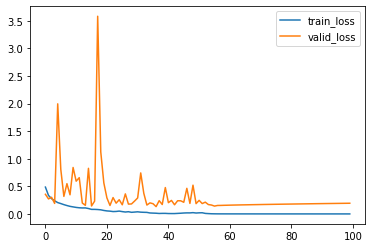

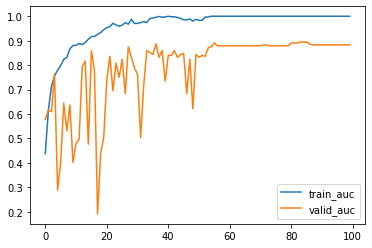

In [41]:
device = 'cuda:0'
model = model.to(device)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

In [42]:
torch.save(model.state_dict(),'senet20_2021_0604_1345_randomseed210.pt')

In [43]:
model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=6)
model.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])

Using cache found in /root/.cache/torch/hub/moskomule_senet.pytorch_master


In [44]:
model.load_state_dict(torch.load('senet20_2021_0604_1345_randomseed210.pt'))
model.eval()

DataParallel(
  (module): CifarSEResNet(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): CifarSEBasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SELayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=1, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=1, out_features=16, bias=False

# model infernce test

In [45]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [46]:
cm,acc = plot_confusion_matrix(model.to(device),train_iter)
print(acc)
cm

100%|██████████| 30/30 [00:01<00:00, 16.15it/s]

0.9687174139728885


Barking  Howling  Crying  COSmoke  GlassBreaking  Vacuum
0      158        3       7        1              3       2
1        2      152       3        0              0       2
2        0        5     149        0              0       1
3        0        0       0      159              0       0
4        0        0       0        0            156       0
5        0        0       1        0              0     155

In [47]:
cm,acc = plot_confusion_matrix(model.to(device),vaild_iter)
print(acc)
cm

100%|██████████| 8/8 [00:01<00:00,  7.07it/s]

0.8833333333333333


Barking  Howling  Crying  COSmoke  GlassBreaking  Vacuum
0       37        2       5        0              1       0
1        1       34       4        0              0       1
2        2        4      30        0              0       2
3        0        0       1       40              0       1
4        0        0       0        0             38       3
5        0        0       0        0              1      33

# submit

In [48]:
print(X_test.shape[0])

10000


In [49]:
sample_submit = pd.read_csv('sample_submission.csv')
model = model.to('cuda:0')
model.eval()
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 100/100 [00:04<00:00, 24.70it/s]


Filename   Barking    Howling     Crying   COSmoke  GlassBreaking  \
0       public_00001 -6.066834  -6.519832  -7.774446 -5.304582       0.434770   
1       public_00002 -3.358423  -6.915194  -7.001850 -2.261960      -6.282775   
2       public_00003  6.387370  -6.186183 -10.964597 -7.161757     -10.160254   
3       public_00004 -3.966606  -4.582035  -4.821635 -3.803969      -2.599441   
4       public_00005  8.735122 -10.057693  -9.494844 -5.425406      -9.967094   
...              ...       ...        ...        ...       ...            ...   
29995  private_19996  0.166600   0.166600   0.166600  0.166600       0.166600   
29996  private_19997  0.166600   0.166600   0.166600  0.166600       0.166600   
29997  private_19998  0.166600   0.166600   0.166600  0.166600       0.166600   
29998  private_19999  0.166600   0.166600   0.166600  0.166600       0.166600   
29999  private_20000  0.166600   0.166600   0.166600  0.166600       0.166600   

           Other  
0      -3.645984  
1       2.162924  
2      -8.189247  
3      -0.698311  
4     -10.245211  
...          ...  
29995   0.167000  
29996   0.167000  
29997   0.167000  
29998   0.167000  
29999   0.167000  

[30000 rows x 7 columns]

In [50]:
from scipy.special import softmax
a = softmax(sample_submit.iloc[:,1:].values,axis=1)
a

array([[1.46751290e-03, 9.32926719e-04, 2.66057714e-04, 3.14502509e-03,
        9.77670988e-01, 1.65174899e-02],
       [3.93586824e-03, 1.12293500e-04, 1.02972335e-04, 1.17822564e-02,
        2.11354135e-04, 9.83855255e-01],
       [9.99994671e-01, 3.46236591e-06, 2.91161688e-08, 1.30522789e-06,
        6.50812129e-08, 4.67146665e-07],
       ...,
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01],
       [1.66655554e-01, 1.66655554e-01, 1.66655554e-01, 1.66655554e-01,
        1.66655554e-01, 1.66722230e-01]])

In [51]:
sample_submit.iloc[:,1:] = a
sample_submit

Filename   Barking       Howling        Crying       COSmoke  \
0       public_00001  0.001468  9.329267e-04  2.660577e-04  3.145025e-03   
1       public_00002  0.003936  1.122935e-04  1.029723e-04  1.178226e-02   
2       public_00003  0.999995  3.462366e-06  2.911617e-08  1.305228e-06   
3       public_00004  0.030000  1.621243e-02  1.275825e-02  3.529859e-02   
4       public_00005  0.999999  6.892610e-09  1.210113e-08  7.082080e-07   
...              ...       ...           ...           ...           ...   
29995  private_19996  0.166656  1.666556e-01  1.666556e-01  1.666556e-01   
29996  private_19997  0.166656  1.666556e-01  1.666556e-01  1.666556e-01   
29997  private_19998  0.166656  1.666556e-01  1.666556e-01  1.666556e-01   
29998  private_19999  0.166656  1.666556e-01  1.666556e-01  1.666556e-01   
29999  private_20000  0.166656  1.666556e-01  1.666556e-01  1.666556e-01   

       GlassBreaking         Other  
0       9.776710e-01  1.651749e-02  
1       2.113541e-04  9.838553e-01  
2       6.508121e-08  4.671467e-07  
3       1.177274e-01  7.880031e-01  
4       7.546236e-09  5.714077e-09  
...              ...           ...  
29995   1.666556e-01  1.667222e-01  
29996   1.666556e-01  1.667222e-01  
29997   1.666556e-01  1.667222e-01  
29998   1.666556e-01  1.667222e-01  
29999   1.666556e-01  1.667222e-01  

[30000 rows x 7 columns]

In [52]:
sample_submit.sum(axis=1)

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
29995    1.0
29996    1.0
29997    1.0
29998    1.0
29999    1.0
Length: 30000, dtype: float64

In [53]:
# save
sample_submit.to_csv('senet20_2021_0604_1345_randomseed210.csv',index=False)
print('done')

done
